In [1]:
!python --version

Python 3.10.13


In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.7 MB/s eta 0:00:00


In [3]:
!pip install split-folders

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders

import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import pennylane as qml
from pennylane.templates import RandomLayers
import numpy as np

import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-03-29 18:58:22.247764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 18:58:22.247894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 18:58:22.423786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
img_height,img_width=224,224

batch_size=32

# Data Preparation

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import pennylane as qml
from pennylane.templates import RandomLayers
import numpy as np

import matplotlib.pyplot as plt
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [7]:
def split_data(data_path, output_path):
    train_data_dir =  data_path + '/train' 
    val_data_dir =  data_path + '/val'
    test_data_dir = data_path + '/test'
    
    
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      val_data_dir,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_data_dir,
        batch_size=batch_size,
        image_size=(img_height, img_width),
        seed=123
    )
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = split_data('/kaggle/input/knee-osteoarthritis-dataset-with-severity', '/kaggle/working/atpos')

Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


In [10]:
class_names = val_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


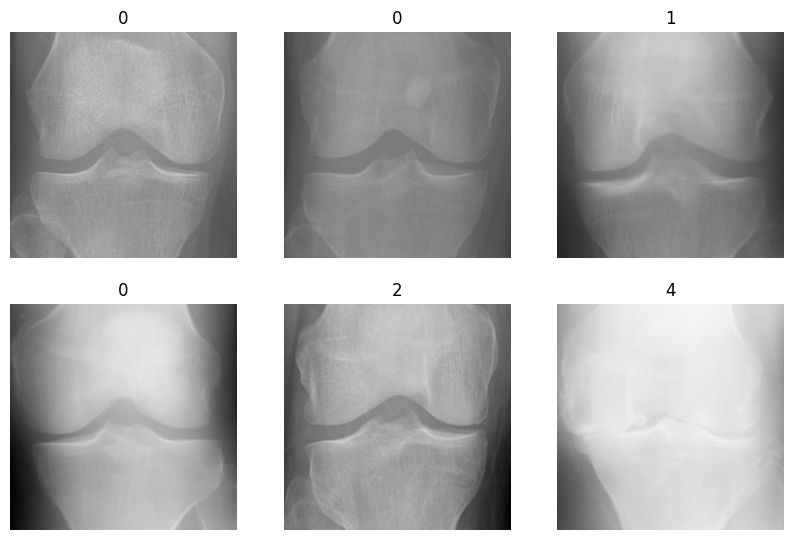

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
!nvidia-smi

Fri Mar 29 18:58:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W /  70W |  14053MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# MODEL TRAINING


In [13]:
tf.keras.backend.set_floatx('float32')

## QUANTUM PART

In [14]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [15]:
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}

In [16]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## CLASSICAL PART

In [17]:
INPUT = (img_height,img_width, 3)

In [18]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten

In [19]:
def show_results(pretrained_model, epochs, lr):
    model = Sequential()

    for layer in pretrained_model.layers:
            layer.trainable=False

    model.add(pretrained_model)
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(qlayer)
    model.add(Dense(5, activation='softmax'))
    
    
    model.summary()
    
    
    model.compile(optimizer=Adam(lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    
    loss, accuracy = model.evaluate(test_ds)

In [20]:
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import Adam


def show_results_ensemble(epochs, lr):
    # Load pre-trained models
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze convolutional layers
    for layer in vgg16_model.layers:
        layer.trainable = False
    for layer in vgg19_model.layers:
        layer.trainable = False
    for layer in resnet_model.layers:
        layer.trainable = False

    # Define your custom layers
    qlayer = ...  # Define qlayer here

    # Define inputs
    inputs = Input(shape=(224, 224, 3))

    # Get features from each pre-trained model
    vgg16_features = vgg16_model(inputs)
    vgg19_features = vgg19_model(inputs)
    resnet_features = resnet_model(inputs)

    # Flatten each feature set
    vgg16_features = Flatten()(vgg16_features)
    vgg19_features = Flatten()(vgg19_features)
    resnet_features = Flatten()(resnet_features)

    # Concatenate features
    concatenated_features = Concatenate()([vgg16_features, vgg19_features, resnet_features])

    # Pass through your custom layers
    x = Dense(128, activation='relu')(concatenated_features)
    x = Dense(32, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile and train model
    model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    
    loss, accuracy = model.evaluate(test_ds)

# Ensemble

In [21]:
show_results_ensemble(30, 0.001)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['input_4[0][0]']             
                                                          4                                       
                             

I0000 00:00:1711738746.529394      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 [==============================] - 107s 497ms/step - loss: 1.6933 - accuracy: 0.3787 - val_loss: 1.5444 - val_accuracy: 0.3971
Epoch 2/30
181/181 [==============================] - 80s 440ms/step - loss: 1.5198 - accuracy: 0.3956 - val_loss: 1.4992 - val_accuracy: 0.3971
Epoch 3/30
181/181 [==============================] - 81s 444ms/step - loss: 1.4820 - accuracy: 0.3956 - val_loss: 1.4689 - val_accuracy: 0.3971
Epoch 4/30
181/181 [==============================] - 81s 445ms/step - loss: 1.4568 - accuracy: 0.3956 - val_loss: 1.4489 - val_accuracy: 0.3971
Epoch 5/30
181/181 [==============================] - 81s 446ms/step - loss: 1.4400 - accuracy: 0.3956 - val_loss: 1.4355 - val_accuracy: 0.3971
Epoch 6/30
181/181 [==============================] - 81s 447ms/step - loss: 1.4286 - accuracy: 0.3956 - val_loss: 1.4264 - val_accuracy: 0.3971
Epoch 7/30
181/181 [==============================] - 81s 447ms/step - loss: 1.4208 - accuracy: 0.3956 - val_loss: 1.4201 - val_accuracy: 0.

### ResNet

In [22]:
resnet_model = pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(resnet_model, 30, 0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 keras_layer (KerasLayer)    (None, 4)                 1

### VGG19

In [23]:
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(vgg19_model, 30, 0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
 dense_12 (Dense)            (None, 4)                 36        
                                                                 
 keras_layer (KerasLayer)    (None, 4)                

### Mobilenet

In [24]:
mobilenet_model = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(vgg19_model, 30, 0.001)

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dense_15 (Dense)            (None, 32)                4128      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                       

### InceptionNet

In [25]:
inceptionnet_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(inceptionnet_model, 30, 0.001)

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 128)               262272    
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dense_21 (Dense)            (None, 8)                 264       
                                                                 
 dense_22 (Dense)            (None, 4)                 36        
                                                       

### VGG16

In [26]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(vgg16_model, 30, 0.001)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               65664     
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                                 
 dense_26 (Dense)            (None, 8)                 264       
                                                                 
 dense_27 (Dense)            (None, 4)                 36        
                                                                 
 keras_layer (KerasLayer)    (None, 4)                

### XceptionNet

In [27]:
xception_model = tf.keras.applications.xception.Xception(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(xception_model, 30, 0.001)

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_29 (Dense)            (None, 128)               262272    
                                                                 
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dense_31 (Dense)            (None, 8)                 264       
                                                                 
 dense_32 (Dense)            (None, 4)                 36        
                                                       

### Resnet152

In [28]:
resnet152_model = tf.keras.applications.resnet.ResNet152(include_top=False,
                   input_shape=INPUT,
                   pooling='avg',classes=5,
                   weights='imagenet')

show_results(resnet152_model, 30, 0.001)

234698864/234698864 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 128)               262272    
                                                                 
 dense_35 (Dense)            (None, 32)                4128      
                                                                 
 dense_36 (Dense)            (None, 8)                 264       
                                                                 
 dense_37 (Dense)            (None, 4)                 36        
                                                     